In [3]:

import EegFunctions
import importlib
importlib.reload(EegFunctions)
from EegFunctions import *
%matplotlib qt

In [4]:
class Config:
    """Configuration settings for P300 analysis"""
    
    # File paths
    
    DATA_FILE =  r'C:\Users\Keerti\Downloads\MySolution\PlayBooks\data\1_MMN_preprocessed.set'
    RESULTS_DIR = "C:/Users/Keerti/Downloads/MySolution/EEG-ExPy/tests/Analysis/processing_result"
    SESSION_TYPE = 'baseline_post_reflection_unicorn'
    
    # Device configuration
    DEVICE = 'unicorn'  # 'muse' or 'unicorn'
    SAMPLING_RATE = 250
    CHANNELS = ['TP9', 'AF7', 'AF8', 'TP10'] if DEVICE == 'muse' else ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
    ANALYSIS_CHANNELS = ['TP9', 'TP10'] if DEVICE == 'muse' else [ 'Pz','Cz']
    
    # Filtering parameters
    HIGH_PASS = 0.1
    LOW_PASS = 30
    NOTCH_FREQ = [60]
  
       # Channels for P300 analysis
    
    # Epoching parameters
    EPOCH_TMIN = -0.1
    EPOCH_TMAX = 0.6
    BASELINE = (-0.1, 0)
    

In [5]:
raw,df = create_mne_raw(Config.DATA_FILE)
events,event_ids,stimulus_count = extract_events(raw=raw)
Config.EPOCH_TMAX = 0.8
Config.EPOCH_TMIN = -0.2
Config.BASELINE = (-0.2,0)
Config.EVENT_DICT = event_ids


epochs = create_epochs(raw, events,Config)
bin_1_idx, bin_2_idx = create_bins(events)
print(f"Bin 1 (Deviant preceded by Standard) trials: {len(bin_1_idx)}")
print(f"Bin 2 (Standard preceded by Standard) trials: {len(bin_2_idx)}")
epochs_bin1 = epochs[bin_1_idx]  # Deviant preceded by standard
epochs_bin2 = epochs[bin_2_idx]
print(len(epochs_bin1), len(epochs_bin2))

=== CREATING MNE OBJECT ===
=== EXTRACTING EVENTS ===

Found 1002 annotations:
  180: 15 occurrences
  80: 785 occurrences
  1: 2 occurrences
  70: 200 occurrences
Used Annotations descriptions: [np.str_('1'), np.str_('180'), np.str_('70'), np.str_('80')]
=== CREATING EPOCHS ===
Not setting metadata
1002 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1002 events and 257 original time points ...
0 bad epochs dropped
1: 2
180: 15
70: 200
80: 785
Created epochs - 1: 2, 180: 15, 70: 200, 80: 785
Bin 1 (Deviant preceded by Standard) trials: 200
Bin 2 (Standard preceded by Standard) trials: 585
200 585


# Interpolate C5

In [6]:
montage = mne.channels.make_standard_montage('standard_1020')
eog_channels = ['HEOG-left', 'HEOG-right', 'VEOG-lower', 'HEOG-bipolar', 'VEOG-bipolar']
channel_types = {ch: 'eog' for ch in eog_channels}
raw.set_channel_types(channel_types)
raw.set_montage(montage, match_case=False)

ch_to_interpolate = ['C5'] 
exclude_channels = ['HEOG-bipolar', 'VEOG-bipolar']  
info = raw.info.copy()
raw_interpolated = raw.copy()
raw_interpolated.info['bads'] = ch_to_interpolate
picks_for_interp = mne.pick_types(raw_interpolated.info, eeg=True, exclude=exclude_channels)
ch_names_for_interp = [raw_interpolated.ch_names[i] for i in picks_for_interp]


raw_interpolated.interpolate_bads(reset_bads=True, method=dict(eeg='spline'))

print(f"Interpolated channel: {ch_to_interpolate}")
print(f"Excluded from interpolation: {exclude_channels}")
print("Interpolation completed using spherical method")
mne.export.export_raw('data/1_MMN_preprocessed_interp.set', raw_interpolated, fmt='eeglab',overwrite=True)

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.6 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 1 sensors
Interpolated channel: ['C5']
Excluded from interpolation: ['HEOG-bipolar', 'VEOG-bipolar']
Interpolation completed using spherical method


=== CREATING EPOCHS ===
Not setting metadata
1002 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1002 events and 257 original time points ...
0 bad epochs dropped
1: 2
180: 15
70: 200
80: 785
Created epochs - 1: 2, 180: 15, 70: 200, 80: 785
Using matplotlib as 2D backend.


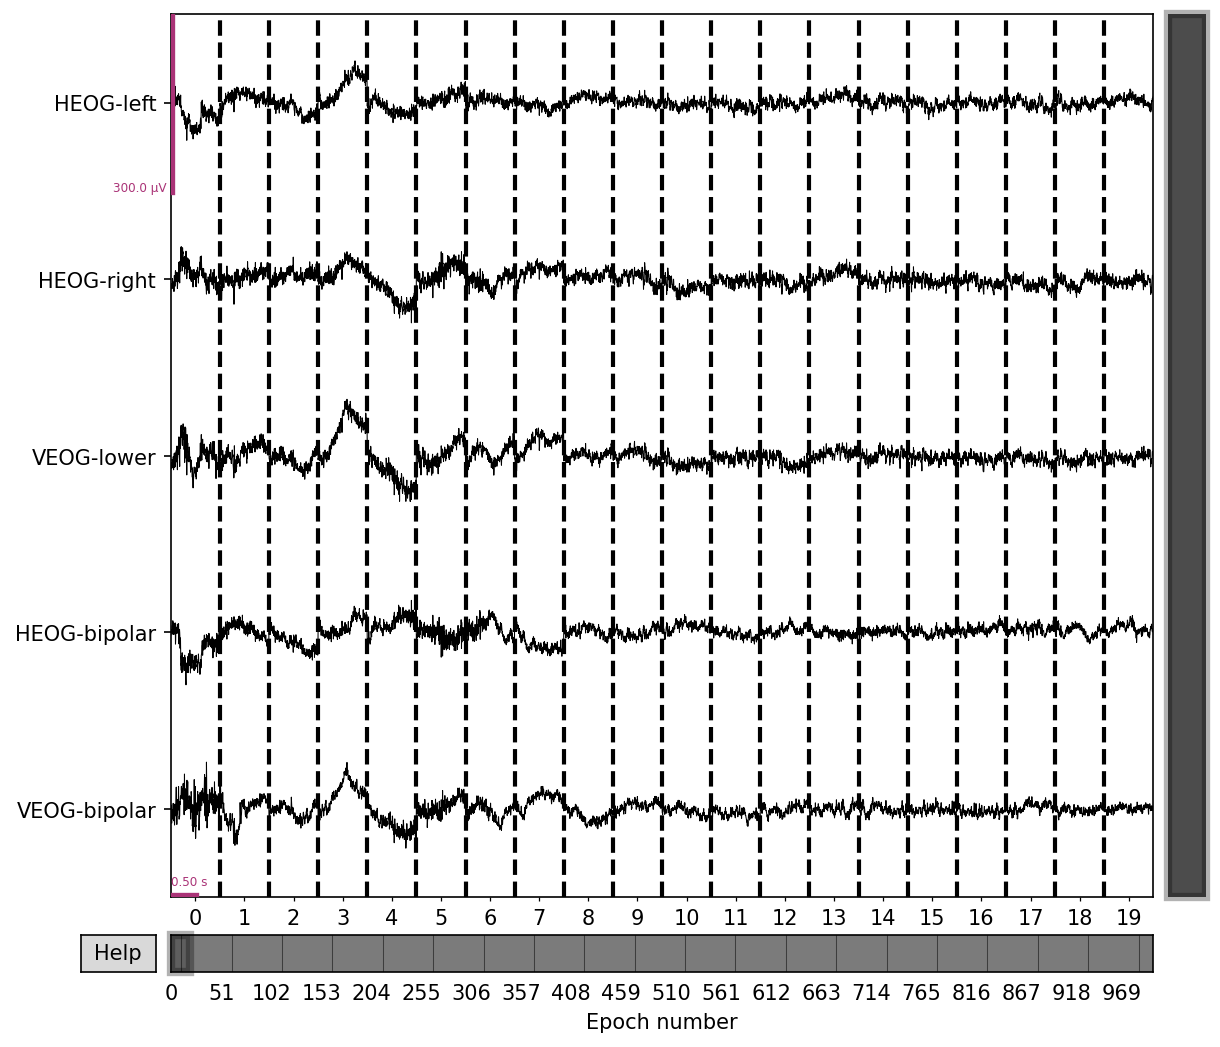

In [7]:
epochs_interpolated = create_epochs(raw_interpolated, events,Config)
epochs_interpolated.plot(picks='eog')

In [8]:
def detect_blink_artifacts(epochs, channel='VEOG-bipolar', voltage_limits=(-100e-6, 100e-6)):
   
    if channel not in epochs.ch_names:
        raise ValueError(f"Channel {channel} not found in epochs")
    
    ch_idx = epochs.ch_names.index(channel)
    print(f"Using channel {channel} (index {ch_idx}) for blink detection")
    data = epochs.get_data()[:, ch_idx, :]  
    min_voltage, max_voltage = voltage_limits
    bad_epochs = np.any((data < min_voltage) | (data > max_voltage), axis=1)
    
    # Report results
    n_bad = np.sum(bad_epochs)
    n_total = len(epochs)
    print(f"Blink detection results:")
    print(f"  Voltage limits: {min_voltage*1e6:.0f} to {max_voltage*1e6:.0f} μV")
    print(f"  Bad epochs detected: {n_bad}/{n_total} ({n_bad/n_total*100:.1f}%)")
    # print(f"  Bad epoch indices: {np.where(bad_epochs)[0]}")
    
    return bad_epochs

# Apply blink detection
bad_epochs = detect_blink_artifacts(epochs_interpolated, 
                                   channel='VEOG-bipolar', 
                                   voltage_limits=(-100e-6, 100e-6))

# Mark bad epochs in the epochs object
epochs_interpolated.drop_log = [None] * len(epochs_interpolated)

# Mark bad epochs
for i, is_bad in enumerate(bad_epochs):
    if is_bad:
        # print(f"Marking epoch {i} as bad due to blink artifact")
        epochs_interpolated.drop_log[i] = ["BLINK_ARTIFACT"]

print(f"\nMarked {np.sum(bad_epochs)} epochs for rejection due to blinks")

# mne.export.export_raw('data/1_MMN_preprocessed_interp_be_ar100.set', raw_interpolated, fmt='eeglab',overwrite=True)

Using channel VEOG-bipolar (index 32) for blink detection
Blink detection results:
  Voltage limits: -100 to 100 μV
  Bad epochs detected: 173/1002 (17.3%)

Marked 173 epochs for rejection due to blinks


In [12]:
plot_bad_epochs(epochs_interpolated,bad_epochs,'VEOG-bipolar',n_epochs_to_plot=15,title="Blink Artifact Detection")

# Data Quality and Confounds

In [224]:
import numpy as np
epochs_bc = epochs_interpolated.copy().apply_baseline((-0.2, 0))
ch_name = 'FCz'
tmin, tmax = 0.125, 0.225  # 125–225 ms window
mask = (epochs_bc.times >= tmin) & (epochs_bc.times <= tmax)

bins = list(epochs_bc.event_id.keys())  
aSME_dict = {}
for b in bins:
    data = epochs_bc[b].get_data()[:, epochs_bc.ch_names.index(ch_name), :] * 1e6  # volts → μV
    trial_means = data[:, mask].mean(axis=1)  # mean per trial in window
    aSME = trial_means.std() / np.sqrt(trial_means.size)  # standard error across trials
    aSME_dict[b] = aSME

for b, val in aSME_dict.items():
    print(f"aSME FCz 125–225 ms ({b}): {val:.4f} μV")

Applying baseline correction (mode: mean)
aSME FCz 125–225 ms (1): 1.2788 μV
aSME FCz 125–225 ms (180): 2.2880 μV
aSME FCz 125–225 ms (70): 0.5518 μV
aSME FCz 125–225 ms (80): 0.3059 μV


In [13]:
import matplotlib.pyplot as plt
from mne.viz import plot_compare_evokeds

# Average epochs per condition
eog_channels = ["VEOG-bipolar", "VEOG-lower"]
bad_indices = [i for i, reason in enumerate(epochs_interpolated.drop_log) if reason]
# epochs_plot = epochs_interpolated.copy()
# epochs_plot = epochs_interpolated[bad_indices].copy()
epochs_plot = epochs_interpolated.copy()
epochs_plot.drop_bad()
epochs_plot.set_channel_types({ch: "eeg" for ch in eog_channels})

evokeds = epochs_plot.average(by_event_type=True,picks='all')

# Channels to plot individually
channels = ["FP2", "VEOG-lower", "VEOG-bipolar", "FCz"]
n_channels = len(channels)

# Create subplots
fig, axes = plt.subplots(n_channels, 1, figsize=(10, 2.5 * n_channels), sharex=True)

# Plot each channel separately using plot_compare_evokeds
for ax, ch_name in zip(axes, channels):
    plot_compare_evokeds(
        {"standard": evokeds[3], "deviant": evokeds[2]},
        picks=[ch_name],
        axes=[ax],
        combine=None,  # plot each channel individually
        colors={"standard": "blue", "deviant": "red"},
        truncate_yaxis=False,
    )
    ax.set_title(ch_name)

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()


C:\Users\Keerti\AppData\Local\Temp\ipykernel_1448\702705320.py:24: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  plot_compare_evokeds(
C:\Users\Keerti\AppData\Local\Temp\ipykernel_1448\702705320.py:24: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  plot_compare_evokeds(
C:\Users\Keerti\AppData\Local\Temp\ipykernel_1448\702705320.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
